In [1]:
from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine
from sqlmodel import Session, select
import pandas as pd
import seaborn as sns
import opinionated
import colormaps as cmaps
import matplotlib.pyplot as plt

plt.style.use("opinionated_rc")

# get a dataset of linked repos and papers
data = []
engine = get_engine(prod=True)
with Session(engine) as session:
    statement = select(
        db_models.DocumentRepositoryLink,
        db_models.Document,
        db_models.Repository,
    ).join(
        db_models.Document,
    ).join(
        db_models.Repository,
    )

    # For each one, we need to get count of contributors for document and repository
    for link, document, repository in session.exec(statement):
        # Also keep track of how many of each type by position their are
        # i.e. how many first authors are matched to devs,
        # how many middle authors are matched to devs, etc.

        # Create and exec doc statement
        doc_contrib_statement = select(db_models.DocumentContributor).where(
            db_models.DocumentContributor.document_id == document.id
        )
        doc_contribs = list(session.exec(doc_contrib_statement))
        doc_contribs_lut = {contrib.id: contrib for contrib in doc_contribs}

        # Create and exec repo statement
        repo_contrib_statement = select(db_models.RepositoryContributor).where(
            db_models.RepositoryContributor.repository_id == repository.id
        )
        repo_contribs = list(session.exec(repo_contrib_statement))
        repo_contribs_lut = {contrib.id: contrib for contrib in repo_contribs}

        # For each doc contrib, check if linked to repo contrib
        matched_contribs_by_position = {}
        for doc_contrib in doc_contribs:
            for repo_contrib in repo_contribs:
                this_doc_contrib_repo_contribs_statement = select(
                    db_models.ResearcherDeveloperAccountLink
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.researcher_id
                        == doc_contrib.researcher_id
                    )
                ).where(
                    (
                        db_models.ResearcherDeveloperAccountLink.developer_account_id
                        == repo_contrib.developer_account_id
                    )
                )
                matched_contrib = session.exec(this_doc_contrib_repo_contribs_statement).first()
                if matched_contrib:
                    position = doc_contrib.position
                    if position not in matched_contribs_by_position:
                        matched_contribs_by_position[position] = []
                    matched_contribs_by_position[position].append(matched_contrib)

        # Calc all n_contribs
        n_doc_contributors = len(doc_contribs)
        n_repo_contributors = len(repo_contribs)
        n_matched_contributors = sum([len(v) for v in matched_contribs_by_position.values()])
        n_matched_contribs_by_position = {
            f"n_matched_{k}_position_contributors": len(v) for k, v in matched_contribs_by_position.items()
        }

        # Get the primary field (field with highest "score" attribute in document topic)
        try:
            primary_document_topic_stmt = select(db_models.DocumentTopic).where(
                db_models.DocumentTopic.document_id == document.id
            ).order_by(db_models.DocumentTopic.score.desc()).limit(1)
            primary_document_topic = session.exec(primary_document_topic_stmt).first()

            # Resolve to field name by querying for document
            primary_topic_stmt = select(db_models.Topic).where(
                db_models.Topic.id == primary_document_topic.topic_id
            )
            primary_topic = session.exec(primary_topic_stmt).first()
        except:
            continue

        # Append to data
        data.append(
            {
                "document_id": document.id,
                "paper_doi": document.doi,
                "publication_date": document.publication_date,
                "cited_by_count": document.cited_by_count,
                "cited_by_percentile_year_min": document.cited_by_percentile_year_min,
                "field": primary_topic.field_name,
                "repository_id": repository.id,
                "owner": repository.owner,
                "name": repository.name,
                "forks_count": repository.forks_count,
                "stargazers_count": repository.stargazers_count,
                "watchers_count": repository.watchers_count,
                "open_issues_count": repository.open_issues_count,
                "size_kb": repository.size_kb,
                "creation_datetime": repository.creation_datetime,
                "last_pushed_datetime": repository.last_pushed_datetime,
                "n_doc_contributors": n_doc_contributors,
                "n_repo_contributors": n_repo_contributors,
                "n_matched_contributors": n_matched_contributors,
                **n_matched_contribs_by_position,
            }
        )

data = pd.DataFrame(data)
data = data.fillna(0)
data.sample(3)

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

,document_id,paper_doi,publication_date,cited_by_count,cited_by_percentile_year_min,field,repository_id,owner,name,forks_count,...,open_issues_count,size_kb,creation_datetime,last_pushed_datetime,n_doc_contributors,n_repo_contributors,n_matched_contributors,n_matched_first_position_contributors,n_matched_middle_position_contributors,n_matched_last_position_contributors
2883,2893,10.48550/arxiv.2110.03536,2021-01-01,0,0,Computer Science,2874,l3s,prototypesound,3,...,0,242,2021-10-07 07:37:11,2022-10-26 11:15:41,3,2,0,0.0,0.0,0.0
10005,9998,10.48550/arxiv.2112.12560,2021-01-01,0,0,Medicine,9650,tpopordanoska,calibration_and_bias,1,...,0,28,2021-06-20 23:43:27,2021-08-25 13:43:51,5,2,2,1.0,0.0,1.0
22764,22630,10.48550/arxiv.2304.06966,2023-01-01,0,0,Computer Science,21736,nyu-ce-projects,depth-estimation,1,...,1,2990,2022-04-05 21:25:54,2023-06-08 01:36:45,4,3,3,1.0,2.0,0.0


/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_54810/1095803539.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=field_counts, x="field", y="count", hue="field", palette=cmaps.bold._colors)
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_54810/1095803539.py:4: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(data=field_counts, x="field", y="count", hue="field", palette=cmaps.bold._colors)


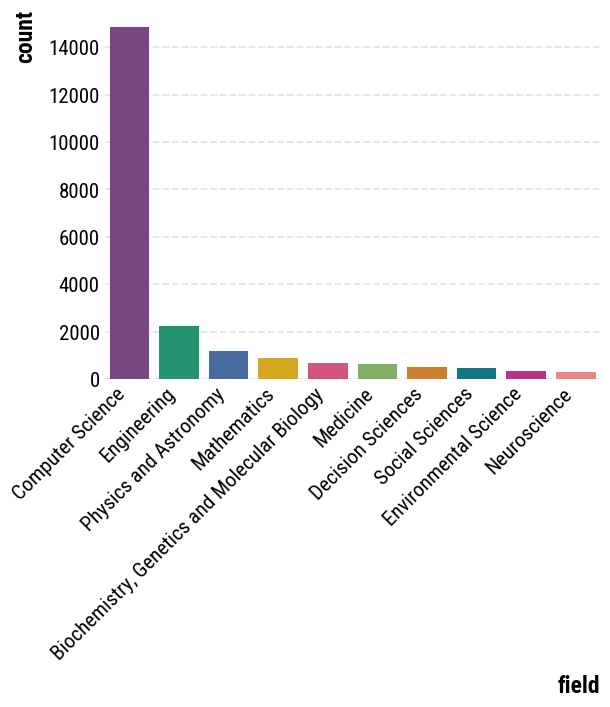

In [12]:
# count plot of fields
field_counts = data["field"].value_counts().reset_index().sort_values("count", ascending=False)
field_counts = field_counts.head(10)
sns.barplot(data=field_counts, x="field", y="count", hue="field", palette=cmaps.bold._colors)
_ = plt.xticks(rotation=45, ha="right")

<Axes: xlabel='publication_year', ylabel='count'>

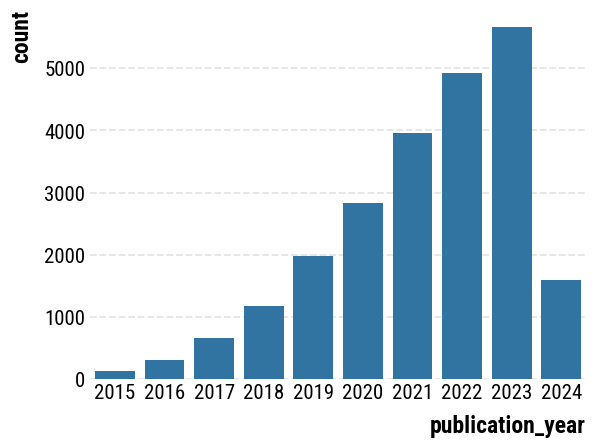

In [21]:
# count papers by year
# cast publication date to dt
data["publication_date"] = pd.to_datetime(data["publication_date"])
data["publication_year"] = data["publication_date"].dt.year
year_counts = data["publication_year"].value_counts().reset_index()

# drop any rows with less than 200 papers
year_counts = year_counts[year_counts["count"] > 50]

sns.barplot(
    data=year_counts,
    x="publication_year",
    y="count",
)

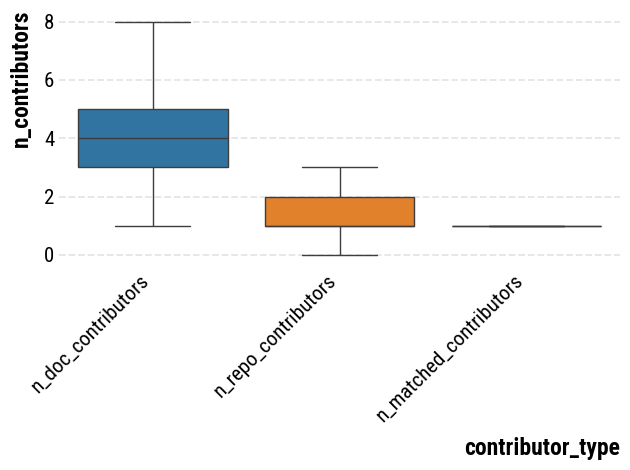

In [23]:
# Melt metrics
data_melted = pd.melt(
    data,
    id_vars="document_id",
    value_vars=[
        "n_doc_contributors",
        "n_repo_contributors",
        "n_matched_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

ax = sns.boxplot(
    data=data_melted,
    x="contributor_type",
    y="n_contributors",
    hue="contributor_type",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")
plt.tight_layout()

In [24]:
# Get descriptive stats for each contributor type and n-contributors
data_melted.groupby("contributor_type")["n_contributors"].describe()

,count,mean,std,min,25%,50%,75%,max
contributor_type,,,,,,,,
n_doc_contributors,23282.0,4.433769,3.475518,1.0,3.0,4.0,5.0,126.0
n_matched_contributors,23282.0,1.261661,1.300183,0.0,1.0,1.0,1.0,29.0
n_repo_contributors,23282.0,2.897818,5.185357,0.0,1.0,1.0,2.0,30.0


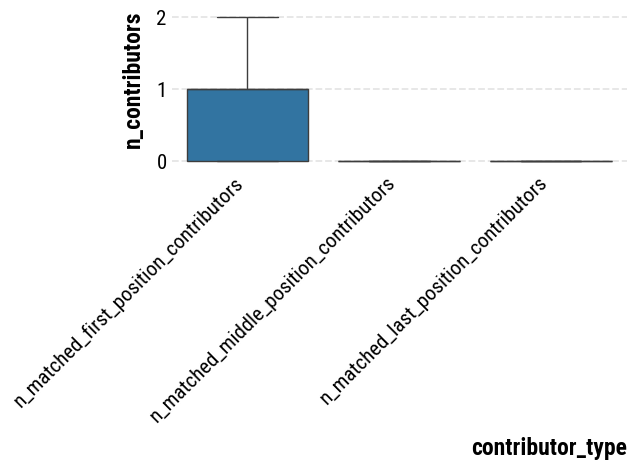

In [6]:
# Melt metrics
data_melted = pd.melt(
    data,
    id_vars="document_id",
    value_vars=[
        "n_matched_first_position_contributors",
        "n_matched_middle_position_contributors",
        "n_matched_last_position_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

ax = sns.boxplot(
    data=data_melted,
    x="contributor_type",
    y="n_contributors",
    hue="contributor_type",
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")
plt.tight_layout()

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_54810/2077494739.py:29: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.lineplot(
/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_54810/2077494739.py:29: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  ax = sns.lineplot(


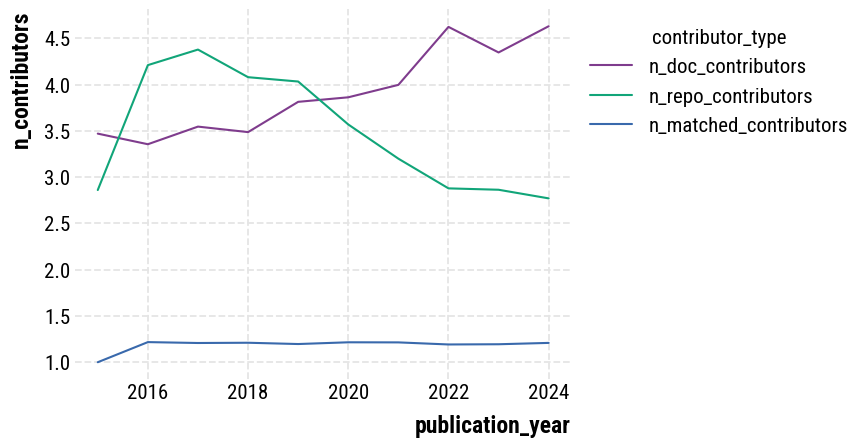

In [31]:
# Line plot of n_doc_contributors, n_repo_contributors, n_matched_contributors over year
data["publication_year"] = data["publication_date"].dt.year

# Only include data from 2015 onwards
data = data[data["publication_year"] >= 2015]

# Group by year and take average of each year for each metrics but remove outliers before average
mean_no_outliers = lambda x: x[(x > x.quantile(0.05)) & (x < x.quantile(0.95))].mean()

data_grouped = data.groupby("publication_year").agg({
    "n_doc_contributors": mean_no_outliers,
    "n_repo_contributors": mean_no_outliers,
    "n_matched_contributors": mean_no_outliers,
}).reset_index()

# melt
data_grouped_melted = pd.melt(
    data_grouped,
    id_vars="publication_year",
    value_vars=[
        "n_doc_contributors",
        "n_repo_contributors",
        "n_matched_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

ax = sns.lineplot(
    data=data_grouped_melted,
    x="publication_year",
    y="n_contributors",
    hue="contributor_type",
    palette=cmaps.bold._colors,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

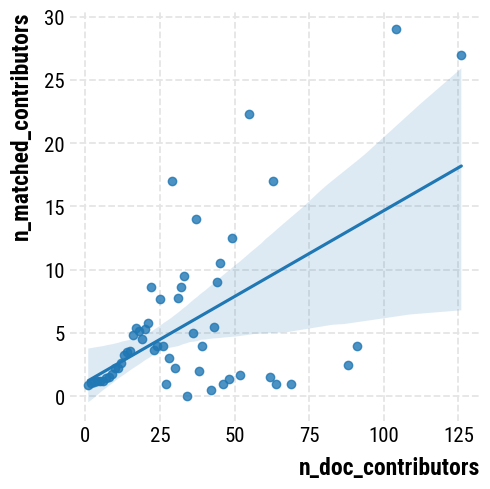

In [32]:
# Group by n doc contributors and take mean of n matched contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_matched_contributors": "mean"}
).reset_index()

sns.lmplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_matched_contributors",
)

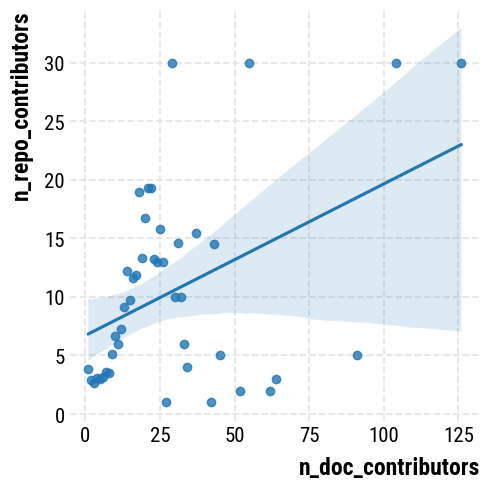

In [6]:
# same thing but with repo contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_repo_contributors": "mean"}
).reset_index()

sns.lmplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_repo_contributors",
)

<Axes: xlabel='n_doc_contributors', ylabel='n_matched_contributors_norm'>

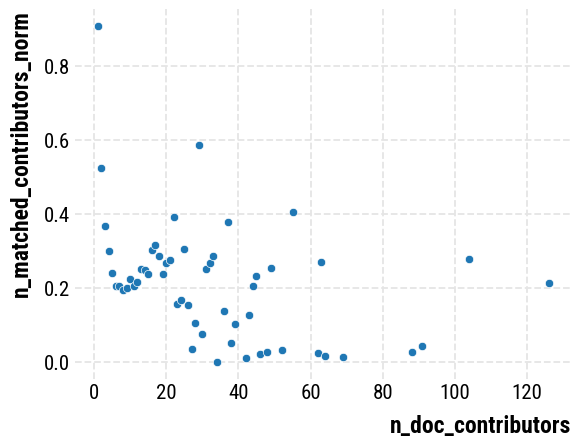

In [33]:
# Same thing but norm by n_doc_contributors
data["n_matched_contributors_norm"] = data["n_matched_contributors"] / data["n_doc_contributors"]

# Groupby n doc contributors and take mean of n matched contributors
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_matched_contributors_norm": "mean"}
).reset_index()

sns.scatterplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_matched_contributors_norm",
)

<Axes: xlabel='n_doc_contributors', ylabel='n_repo_contributors_norm'>

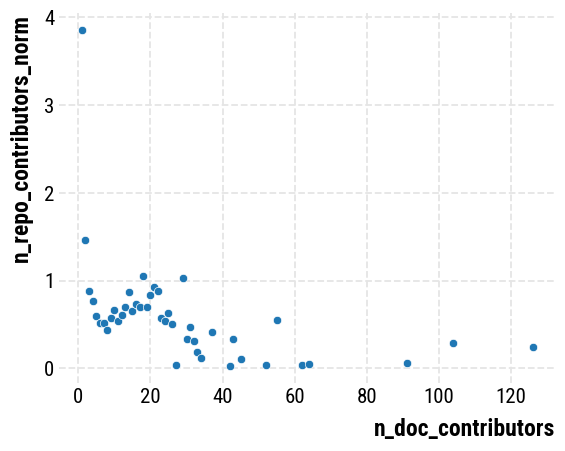

In [8]:
# same thing but with repo contributors
data["n_repo_contributors_norm"] = data["n_repo_contributors"] / data["n_doc_contributors"]
data_grouped = data.groupby("n_doc_contributors").agg(
    {"n_repo_contributors_norm": "mean"}
).reset_index()

sns.scatterplot(
    data=data_grouped,
    x="n_doc_contributors",
    y="n_repo_contributors_norm",
)

<Axes: xlabel='publication_date', ylabel='n_contributors'>

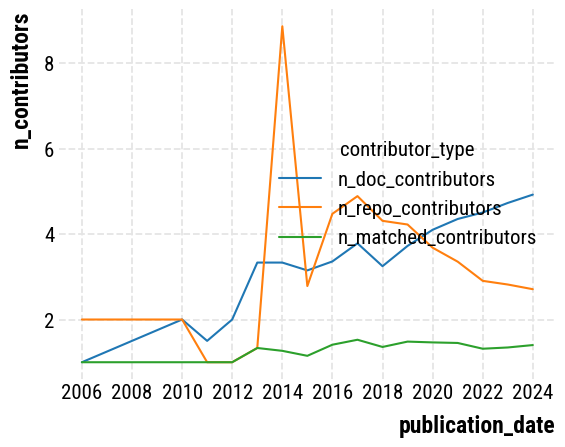

In [9]:
data["publication_date"] = pd.to_datetime(data["publication_date"])

# For each month, take the mean of each contributor type
data["publication_year"] = data["publication_date"].dt.to_period("Y")
data_grouped = data.groupby(["publication_year"]).agg(
    {
        "publication_date": "min",
        "n_doc_contributors": "mean",
        "n_repo_contributors": "mean",
        "n_matched_contributors": "mean",
    }
).reset_index()

data_grouped = pd.melt(
    data_grouped,
    id_vars=["publication_year", "publication_date"],
    value_vars=[
        "n_doc_contributors",
        "n_repo_contributors",
        "n_matched_contributors",
    ],
    var_name="contributor_type",
    value_name="n_contributors",
)

sns.lineplot(
    data=data_grouped,
    x="publication_date",
    y="n_contributors",
    hue="contributor_type",
)

In [10]:
# Create column for "duration between repo creation date and document publication date"
data["duration_to_publication"] = data["publication_date"] - data["creation_datetime"]

# Create column for "duration between repo last push date and document publication date"
data["duration_to_last_push"] = data["publication_date"] - data["last_pushed_datetime"]

# Create column for "duration commit activity"
data["duration_commit_acitivity"] = data["last_pushed_datetime"] - data["creation_datetime"]

data.sample(3)

,document_id,paper_doi,publication_date,cited_by_count,cited_by_percentile_year_min,field,repository_id,owner,name,forks_count,...,n_matched_contributors,n_matched_first_position_contributors,n_matched_middle_position_contributors,n_matched_last_position_contributors,n_matched_contributors_norm,n_repo_contributors_norm,publication_year,duration_to_publication,duration_to_last_push,duration_commit_acitivity
663,664,10.21105/joss.04522,2022-09-23,2,77,Mathematics,663,nhejazi,haldensify,5,...,2,1.0,1.0,0.0,1.000000,1.500000,2022,1347 days 05:16:28,-516 days +17:39:28,1862 days 11:37:00
9382,9379,10.48550/arxiv.2312.00360,2023-01-01,0,0,Computer Science,9041,shaohuadong2021,dplnet,0,...,1,0.0,0.0,1.0,0.166667,0.166667,2023,-333 days +00:24:04,-449 days +07:08:14,115 days 17:15:50
6948,6951,10.48550/arxiv.2312.15258,2023-01-01,0,0,Computer Science,6762,longxiang-ai,human101,1,...,2,1.0,1.0,0.0,0.500000,0.500000,2023,-344 days +16:37:34,-361 days +16:03:06,17 days 00:34:28


<Axes: xlabel='duration_to_publication'>

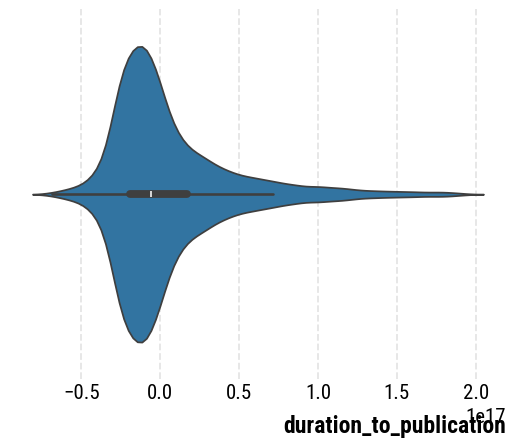

In [11]:
# Distribution of duration_to_publication
# Removing top 1% and bottom 1% of data
sns.violinplot(data=data.loc[
    data["duration_to_publication"].between(
            data["duration_to_publication"].quantile(0.01),
            data["duration_to_publication"].quantile(0.99),
        )
    ],
    x="duration_to_publication",
)

In [12]:
data.loc[data["duration_to_publication"].between(
    data["duration_to_publication"].quantile(0.01),
    data["duration_to_publication"].quantile(0.99),
)].duration_to_publication.describe()

count                          10301
mean      63 days 22:35:14.584797594
std      459 days 15:23:10.068967752
min              -793 days +22:48:46
25%              -222 days +18:42:05
50%               -72 days +21:55:01
75%                197 days 22:12:38
max               2226 days 00:54:04
Name: duration_to_publication, dtype: object

<Axes: xlabel='duration_to_last_push'>

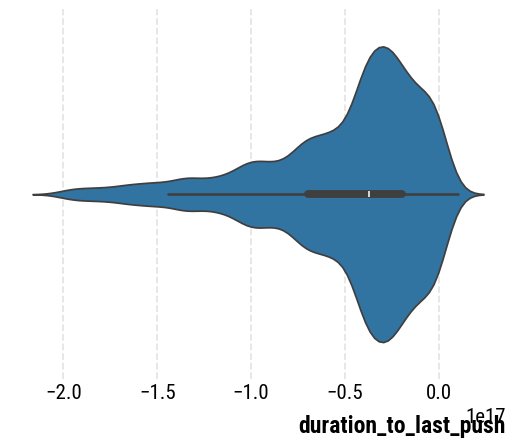

In [13]:
sns.violinplot(data=data.loc[
    data["duration_to_last_push"].between(
            data["duration_to_last_push"].quantile(0.01),
            data["duration_to_last_push"].quantile(0.99),
        )
    ],
    x="duration_to_last_push",
)

In [14]:
data.loc[data["duration_to_last_push"].between(
    data["duration_to_last_push"].quantile(0.01),
    data["duration_to_last_push"].quantile(0.99),
)].duration_to_publication.describe()

count                          10301
mean      72 days 09:18:09.514318998
std      543 days 19:53:53.164180848
min             -2233 days +17:52:46
25%              -228 days +13:21:56
50%               -75 days +13:10:30
75%                190 days 16:21:28
max               4366 days 02:36:18
Name: duration_to_publication, dtype: object

In [15]:
# Find rows with duplicate repository_id
dup_repos = data[data.duplicated(subset=["repository_id"], keep=False)]
for repo, group in dup_repos.groupby("repository_id"):
    # get repo owner and name from first row
    owner = group.iloc[0]["owner"]
    name = group.iloc[0]["name"]
    print(f"https://github.com/{owner}/{name}")
    for paper_doi in group["paper_doi"]:
        print(f"https://doi.org/{paper_doi}")
    print()
    print()


https://github.com/musikisomorphie/swd
https://doi.org/10.48550/arxiv.1904.05408
https://doi.org/10.48550/arxiv.1706.02631


https://github.com/idaholab/moose
https://doi.org/10.21105/joss.06146
https://doi.org/10.21105/joss.03314
https://doi.org/10.21105/joss.02176


https://github.com/pvlib/pvlib-python
https://doi.org/10.21105/joss.05994
https://doi.org/10.21105/joss.00884


https://github.com/jet-net/jetnet
https://doi.org/10.21105/joss.05789
https://doi.org/10.48550/arxiv.2106.11535


https://github.com/roualdes/bridgestan
https://doi.org/10.21105/joss.05236
https://doi.org/10.48550/arxiv.2307.07849
https://doi.org/10.48550/arxiv.2305.10068


https://github.com/mdhaber/scipy
https://doi.org/10.21105/joss.05092
https://doi.org/10.21105/joss.04383


https://github.com/pyamg/pyamg
https://doi.org/10.21105/joss.05495
https://doi.org/10.21105/joss.04142


https://github.com/mlpack/mlpack
https://doi.org/10.21105/joss.05026
https://doi.org/10.21105/joss.00726


https://github.com/symmy5

<Axes: xlabel='duration_commit_acitivity'>

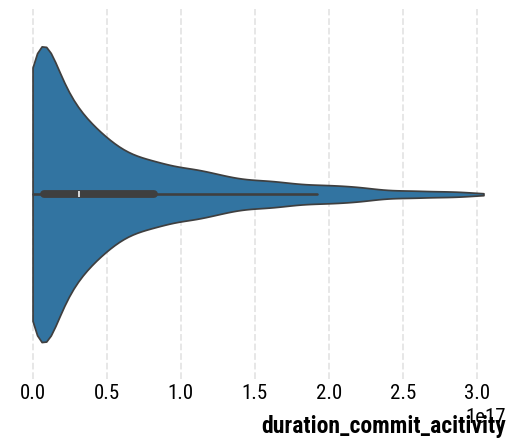

In [16]:
sns.violinplot(
    data=data.loc[
        data["duration_commit_acitivity"].between(
            data["duration_commit_acitivity"].quantile(0.01),
            data["duration_commit_acitivity"].quantile(0.99),
        )
    ],
    x="duration_commit_acitivity",
    cut=0,
)

In [17]:
data.loc[
    data["duration_commit_acitivity"].between(
        data["duration_commit_acitivity"].quantile(0.01),
        data["duration_commit_acitivity"].quantile(0.99),
    )
].duration_commit_acitivity.describe()

count                          10302
mean     637 days 12:17:29.844884488
std      725 days 16:21:58.813181776
min                  0 days 00:01:38
25%          91 days 21:45:49.250000
50%         363 days 03:02:49.500000
75%         944 days 17:27:09.250000
max               3521 days 13:51:43
Name: duration_commit_acitivity, dtype: object

In [18]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

model_data = data[[
    "field",
    "cited_by_count",
    "forks_count",
    "stargazers_count",
    "watchers_count",
    "size_kb",
    "n_doc_contributors",
    "n_repo_contributors",
    "n_matched_contributors",
    "duration_to_publication",
    "duration_commit_acitivity",
]].copy()

# Convert "duration" columns to days
for col in ["duration_to_publication", "duration_commit_acitivity"]:
    model_data[col] = model_data[col].dt.days

# # Remove top 1% and bottom 1% of each metric
# for col in model_data.columns[1:]:
#     q_low = model_data[col].quantile(0.01)
#     q_high = model_data[col].quantile(0.99)
#     model_data = model_data[
#         (model_data[col] > q_low) & (model_data[col] < q_high)
#     ]

# Groupby field, then normalize each metric using log norm
groups = []
for field, group in model_data.groupby("field"):
    group = group.copy()
    for col in model_data.columns[1:]:
        if "duration" in col:
            tr = StandardScaler()
        else:
            tr = PowerTransformer()
        group[col] = tr.fit_transform(group[[col]])
    
    groups.append(group)

model_data = pd.concat(groups)

# remove field column
model_data = model_data.drop(columns=["field"])

<Axes: >

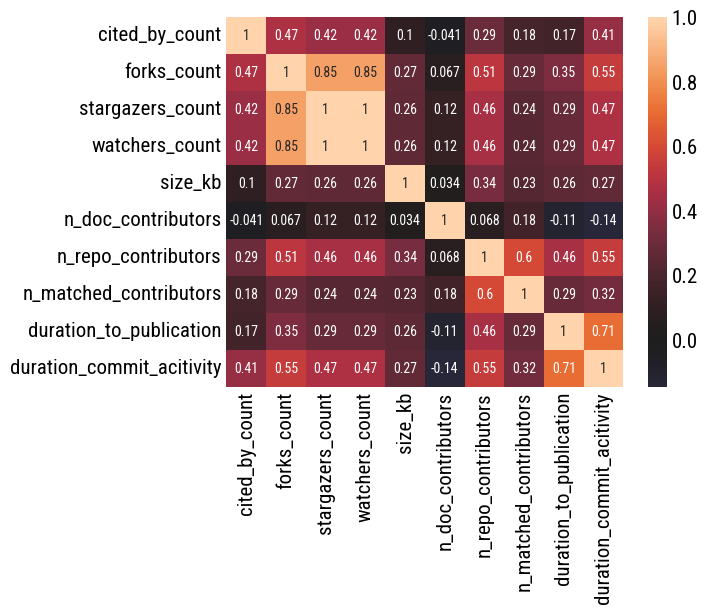

In [19]:
# show correlation across all metrics
corr = model_data.corr()
sns.heatmap(corr, center=0, annot=True)

<Axes: xlabel='publication_year', ylabel='count'>

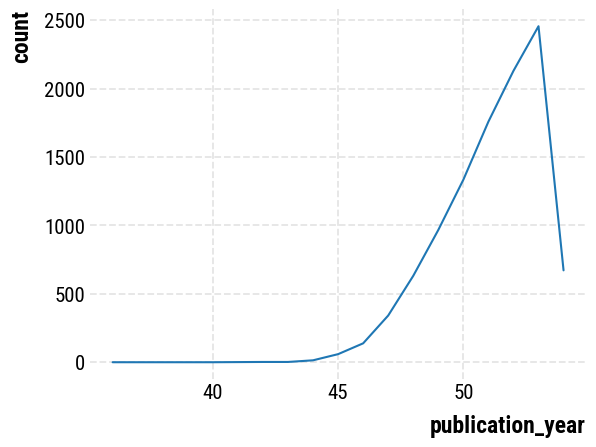

In [20]:
# get count of publications by publication_year
publication_counts = data["publication_year"].value_counts().reset_index()
publication_counts = publication_counts.astype({"publication_year": int})
sns.lineplot(data=publication_counts, x="publication_year", y="count")